Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks   
Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun   
6 Jan 2016   
    
https://arxiv.org/pdf/1506.01497.pdf

In [1]:
import os
import numpy as np
from numpy import random as rng
from PIL import Image
from PIL import ImageDraw

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

---

In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
# (pretrained=False, progress=True, num_classes=91, pretrained_backbone=True,
#      trainable_backbone_layers=None, **kwargs)

model = fasterrcnn_resnet50_fpn(pretrained=True) 
model = model.train(mode=False)

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

---

In [5]:
data_folder = '../data/pascal/VOC/test/VOCdevkit/VOC2007'
img_folder = os.path.join(data_folder,'JPEGImages')
files = os.listdir(img_folder)

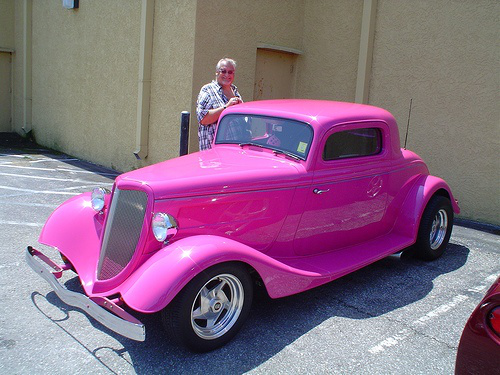

In [29]:
f = rng.choice(files)
img = Image.open(os.path.join(img_folder,f))
img

In [30]:
x = transforms.ToTensor()(img).unsqueeze(dim=0)
with torch.no_grad():
    o = model(x)

In [31]:
boxes = o[0]['boxes'].detach().numpy()
scores = o[0]['scores'].detach().numpy()
labels = o[0]['labels'].detach().numpy()

text = [ 
    '%s %.2f'%( COCO_INSTANCE_CATEGORY_NAMES[labels[n]],scores[n] )
    for n in range(len(labels))
    ]

classes_idx = sorted( set(labels) )
colors = { classes_idx[n]:rng.choice(['blue', 'green', 'orange', 'red', 'yellow'])
          for n in range(len(classes_idx)) }

# colors = rng.randint(127,255,(len(classes_idx),3))
# colors = { classes_idx[n]:tuple(colors[n,:]) for n in range(len(classes_idx)) }

person 1.00
car 0.84
car 0.73


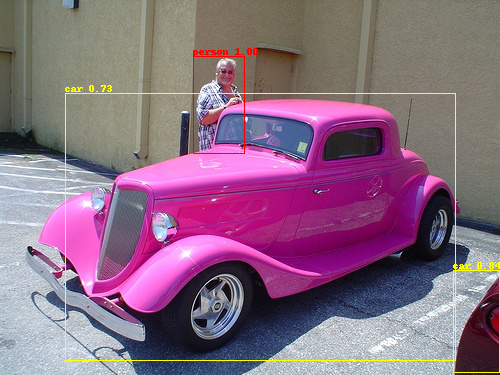

In [32]:
# from PIL import Image 
from PIL import ImageDraw

res = img.copy()
res_draw = ImageDraw.Draw(res)

n=0
for n in range(len(labels)):
    frame = boxes[n,:]
    if scores[n]<0.7:continue
    text_pos = (frame[:2]-np.array([0.,10.])).tolist()
    clr = colors[labels[n]]
    res_draw.rectangle( frame, outline=clr )
    res_draw.text(text_pos,text[n] ,fill=clr)
    print(text[n])

res

---

Mask R-CNN   
Kaiming He Georgia Gkioxari Piotr Dollar Ross Girshick   
Facebook AI Research (FAIR)   
24 Jan 2018

https://arxiv.org/pdf/1703.06870.pdf

In [ ]:
# # x = img2tensor(img)
# x = img_transforms(img).unsqueeze(dim=0)
# with torch.no_grad():
#     o = model(x)

# mask = torch.squeeze(o['out'],dim=0).detach().numpy()
# mask_max_idx = np.argmax(mask,axis=0)

# n_classes = 21

# im_mask = [ (mask_max_idx==c).astype(np.uint8) for c in range(n_classes) ]


-----

In [ ]:
# from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
# from torchvision.ops import misc as misc_nn_ops

In [ ]:
# # Regular resnet50, pretrained on ImageNet, without the classifier and the average pooling layer
# resnet50_1 = torch.nn.Sequential(
#     *(list(
#         torchvision.models.resnet50(
#             pretrained=True, 
#             norm_layer=misc_nn_ops.FrozenBatchNorm2d
#         ).children())[:-2]
#      ))
# resnet50_1.eval()

In [ ]:
# # Resnet50, extract from the Faster R-CNN, also pre-trained on ImageNet
# resnet50_2 = fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True).backbone.body
# resnet50_2.eval()

In [ ]:
# # am too lazy to get a real image
# image = torch.ones((1, 3, 224, 224))
# # Obtaining the model outputs
# with torch.no_grad():
#     # Output from the regular resnet50
#     output_1 = resnet50_1(image)
#     # Output from the resnet50 extracted from the Faster R-CNN
#     output_2 = resnet50_2(image)["3"]
#     # Passes
#     np.testing.assert_almost_equal(output_1.numpy(), output_2.numpy())

In [ ]:
# COCO_PERSON_KEYPOINT_NAMES = [
#     'nose',
#     'left_eye',
#     'right_eye',
#     'left_ear',
#     'right_ear',
#     'left_shoulder',
#     'right_shoulder',
#     'left_elbow',
#     'right_elbow',
#     'left_wrist',
#     'right_wrist',
#     'left_hip',
#     'right_hip',
#     'left_knee',
#     'right_knee',
#     'left_ankle',
#     'right_ankle'
# ]